In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
df_rev = pd.read_csv('/Users/mwirvine/Galvanize/dsi-immersive/one-source-capstone/Data Feeds/ONE - Revenue Data.txt', sep='|')

## Filter on category 20 (booms, scissors, etc), remove credit txns (don't consider invoice credit txns in demand prediction)

df_rev = df_rev[df_rev['Client Category'] == 20]

df_rev = df_rev[df_rev['Rental Revenue'] > 0]


## Drop and reformat columns

cols_to_drop = ['Client Code', 'Client Region', 'CreditAmount', 'Client District', 'Client Category', 'Country', 'Equipment ID #', 'IsSubstitution', 'Description', 'Transaction ID #', 'IsRPO', 'NationalAcctCode', 'Sales Rep #', 'Sales Rep Name', 'Customer Name', 'Minimums', 'IsNationalAcct', 'IsSpecialPricing', 'IsContract', 'ContractPriceNo', 'CycleBillNo', 'Jobsite ZipCode', 'Branch ZipCode', 'CustomerCorpID', 'Customer #', 'Minimum Revenue', 'Minimum Book Revenue']

df_rev.drop(cols_to_drop, axis=1, inplace=True)

cols = df_rev.columns.tolist()
cols = [col.lower() for col in cols]
cols = [col.replace(' ', '_') for col in cols]
df_rev.columns = cols

df_rev.rename(columns={'client_category': 'product_category', 'client_product_type': 'product_type'}, inplace=True)

## Reformat date columns

df_rev['month'] = pd.to_datetime(df_rev['month'])

## Drop 2013/2014 data (all of nulls in contract start date)

df_rev = df_rev[df_rev['month'] > '2014-12-01']

## Reformat ContractStartDate date columns and drop 2013/2014 start dates

df_rev['contractstartdate'] = pd.to_datetime(df_rev['contractstartdate'])
df_rev = df_rev[df_rev['contractstartdate'] >= '2015-01-01']

## Clean up location codes

df_rev['location_code'].replace(['001'], 100, inplace=True)
df_rev['location_code'].replace(['002'], 200, inplace=True)
df_rev['location_code'].replace(['003'], 300, inplace=True)
df_rev['location_code'].replace(['004'], 400, inplace=True)
df_rev['location_code'].replace(['005'], 500, inplace=True)
df_rev['location_code'].replace(['006'], 600, inplace=True)
df_rev['location_code'].replace(['007'], 700, inplace=True)
df_rev['location_code'].replace(['008'], 800, inplace=True)
df_rev['location_code'].replace(['009'], 900, inplace=True)
df_rev['location_code'].replace(['101'], 101, inplace=True)
df_rev['location_code'].replace(['103'], 103, inplace=True)
df_rev['location_code'].replace(['201'], 201, inplace=True)
df_rev['location_code'].replace(['301'], 301, inplace=True)
df_rev['location_code'].replace([1], 100, inplace=True)
df_rev['location_code'].replace([2], 200, inplace=True)
df_rev['location_code'].replace([3], 300, inplace=True)
df_rev['location_code'].replace([4], 400, inplace=True)
df_rev['location_code'].replace([5], 500, inplace=True)
df_rev['location_code'].replace([6], 600, inplace=True)
df_rev['location_code'].replace([7], 700, inplace=True)
df_rev['location_code'].replace([8], 800, inplace=True)
df_rev['location_code'].replace([9], 900, inplace=True)

# Remove two corporate rental invoices
df_rev = df_rev[df_rev['location_code'] != 'COR']

# fill NaNs with 0s (can do this because all NaNs represent zero (e.g., if monthly rental has zero
# weekly revenue, can put weekly rental as 0))

df_rev.fillna(0, inplace=True)

# Remove three hourly rental invoices

df_rev = df_rev[df_rev['hours'] == 0]
df_rev.drop(['hourly_revenue', 'hourly_book_revenue', 'hours'], axis=1, inplace=True)

# Remove excessmileagerevenue and unclassifiedrevenue (< 300 records have these filled)

df_rev.drop(['excessmileagerevenue', 'unclassifiedrevenue'], axis=1, inplace=True)

# Change column to a numeric column

df_rev['location_code'] = pd.to_numeric(df_rev['location_code'])

# Create branch name column (for a dummy later)

conditions = [
    df_rev['location_code'] == 100,
    df_rev['location_code'] == 200,
    df_rev['location_code'] == 300,
    df_rev['location_code'] == 400,
    df_rev['location_code'] == 500,
    df_rev['location_code'] == 600,
    df_rev['location_code'] == 700,
    df_rev['location_code'] == 800,
    df_rev['location_code'] == 900,
    df_rev['location_code'] == 101,
    df_rev['location_code'] == 103,
    df_rev['location_code'] == 201,
    df_rev['location_code'] == 301]

choices = ['LAF', 'KNX', 'DEC', 'GRA', 'MOR', 'TER', 'LOU', 'IND', 'CLA', 'LAF-NUC', 'DEC-STA', 'LAF-FRE', 'LAF-SDI']
df_rev['branch_name'] = np.select(conditions, choices, default='TBD')

# create rental type column (rental was monthly, weekly, daily)

conditions = [
    df_rev['days'] > 0,
    df_rev['weeks'] > 0,
    df_rev['months'] > 0]

choices = ['daily', 'weekly', 'monthly']
df_rev['rental_type'] = np.select(conditions, choices, default='NA')

# create contract start month, year, and year_month columns

df_rev['contract_start_year'] = df_rev['contractstartdate'].dt.year
df_rev['contract_start_month'] = df_rev['contractstartdate'].dt.month
df_rev['contract_start_year_month'] = pd.to_datetime(df_rev['contractstartdate']).map(lambda dt: dt.replace(day=1))

# create units_rented columns (will be target variable)

df_rev['units_rented'] = 1

# Create month dataset

df_month = df_rev[df_rev['rental_type'] == 'monthly']
df_month_agg = df_month.groupby(['product_type', 'contract_start_year_month', 'contract_start_year', 'contract_start_month']).agg({'rental_revenue':'sum', 'months': 'sum', 'monthly_revenue': 'sum', 'units_rented':'count'}).reset_index()
df_month_agg['avg_price_per_month'] = df_month_agg['monthly_revenue'] / df_month_agg['months']
df_month_agg.drop('monthly_revenue', axis=1, inplace=True)
df_month_agg.rename(columns={'months': 'total_months_rented'}, inplace=True)

# Create lag columns (prior month units rented, revenue, etc.)

df_month_agg.sort_values('contract_start_year_month', inplace=True)
df_month_agg.reset_index(drop=True, inplace=True)

def get_month_lag(df, row):
    lag_date = row['contract_start_year_month'] - 1 * MonthBegin()
    mask = (lag_date == df.loc[:, 'contract_start_year_month']) & (row['product_type'] == df.loc[:, 'product_type'])
    lag_df = df.loc[mask, :]
    return lag_df

df_month_agg['prior_month_rental_revenue'] = 0
df_month_agg['prior_month_total_months_rented'] = 0
df_month_agg['prior_month_units_rented'] = 0
df_month_agg['prior_month_avg_price'] = 0

for idx, row in df_month_agg.iterrows():
    lag_df = get_month_lag(df_month_agg, row)
    if lag_df.empty:
        df_month_agg.loc[idx, 'prior_month_rental_revenue'] = None
        df_month_agg.loc[idx, 'prior_month_total_months_rented'] = None
        df_month_agg.loc[idx, 'prior_month_units_rented'] = None
        df_month_agg.loc[idx, 'prior_month_avg_price'] = None
    else:
        df_month_agg.loc[idx, 'prior_month_rental_revenue'] = lag_df['rental_revenue'].values
        df_month_agg.loc[idx, 'prior_month_total_months_rented'] = lag_df['total_months_rented'].values
        df_month_agg.loc[idx, 'prior_month_units_rented'] = lag_df['units_rented'].values
        df_month_agg.loc[idx, 'prior_month_avg_price'] = lag_df['avg_price_per_month'].values

# remove January 2015 data as there is no prior month
df_month_agg = df_month_agg.loc[df_month_agg['contract_start_year_month'] > '2015-01-01', :]

# fill NaNs for prior month features with zeros as there was no prior month rental revenue

df_month_agg.fillna(0, inplace=True)

# drop current month columns as we only have prior month to predict

df_month_agg.drop(['rental_revenue', 'total_months_rented', 'avg_price_per_month'], axis=1, inplace=True)


/Users/mwirvine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
# Dummy function

def create_dummies(dummy_col, df, col_prefix):
    dum_col = df[dummy_col]
    dummies = pd.get_dummies(dum_col, prefix=col_prefix)
    df = df.drop([dummy_col], axis=1)
    df_w_dummies = df.merge(dummies, left_index=True, right_index=True)
    return df_w_dummies

# Create dummies

df_month_agg = create_dummies('product_type', df_month_agg, 'product_type')
df_month_agg = create_dummies('contract_start_year', df_month_agg, 'contract_start_year')
df_month_agg = create_dummies('contract_start_month', df_month_agg, 'contract_start_month')

# create train / test sets (test will be May 2017 - April 2018)
# (train will be Feb 2015 - April 2017) note: may-july 2018 look sparse

df_month_agg = df_month_agg.loc[df_month_agg['contract_start_year_month'] < '2018-05-01', :]

df_month_agg_test = df_month_agg.loc[df_month_agg['contract_start_year_month'] >= '2017-05-01', :]
df_month_agg_train = df_month_agg.loc[df_month_agg['contract_start_year_month'] < '2017-05-01', :]

df_month_agg_test.drop('contract_start_year_month', axis=1, inplace=True)
df_month_agg_train.drop('contract_start_year_month', axis=1, inplace=True)


/Users/mwirvine/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [72]:
def calc_rmse(true, predicted):
    residuals_squared = (predicted - true)**2
    variance = sum(residuals_squared) / len(true)
    rmse = np.sqrt(variance)
    return rmse

In [73]:
X_train = df_month_agg_train.drop('units_rented', axis=1).values
y_train = df_month_agg_train['units_rented'].values
X_test = df_month_agg_test.drop('units_rented', axis=1).values
y_test = df_month_agg_test['units_rented'].values

In [74]:
X_train = df_month_agg_train.drop('units_rented', axis=1).values
y_train = df_month_agg_train['units_rented'].values
X_test = df_month_agg_test.drop('units_rented', axis=1).values
y_test = df_month_agg_test['units_rented'].values

linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred_train_linear = linear.predict(X_train)
y_pred_test_linear = linear.predict(X_test)
r_squared = linear.score(X_train, y_train)
rmse_linear_train = calc_rmse(y_train, y_pred_train_linear)
rmse_linear_test = calc_rmse(y_test, y_pred_test_linear)

print("Linear RMSE train results: {}".format(rmse_linear_train))
print("Linear RMSE test results: {}".format(rmse_linear_test))

Linear RMSE train results: 13.713379583174595
Linear RMSE test results: 13.491973647988017


In [75]:
corr_matrix = df_month_agg_train.corr()
corr_matrix['units_rented'].sort_values(ascending=False)

units_rented                       1.000000
prior_month_total_months_rented    0.796885
prior_month_units_rented           0.796597
product_type_20-220                0.752772
prior_month_rental_revenue         0.349847
product_type_20-240                0.292210
product_type_20-210                0.146875
product_type_20-270                0.090668
product_type_20-847                0.084666
product_type_20-530                0.082483
product_type_20-720                0.079755
product_type_20-170                0.075025
product_type_20-740                0.036099
product_type_20-580                0.034826
product_type_20-810                0.032825
product_type_20-873                0.025913
contract_start_month_1             0.023265
contract_start_month_11            0.016437
product_type_20-820                0.012999
contract_start_year_2015           0.012644
contract_start_month_10            0.009765
contract_start_month_3             0.009667
contract_start_month_12         

In [105]:
#df_month_company_rev = df_month.groupby(['contract_start_year_month']).agg({'rental_revenue':'sum', 'units_rented':'count'}).reset_index()
df_month_company_rev = df_month.groupby(['product_type']).agg({'rental_revenue':'sum', 'units_rented':'count'}).reset_index()
df_rev_sorted = df_month_company_rev.sort_values('rental_revenue', ascending=False).reset_index(drop=True)
df_rev_sorted

,product_type,rental_revenue,units_rented
0,20-873,3490120.997,1217
1,20-925,2956826.000,492
2,20-847,2880052.000,1630
3,20-220,2626011.999,7375
4,20-720,1978938.000,1577
5,20-740,1939630.000,1112
6,20-240,1649209.001,3353
7,20-530,1496076.999,1382
8,20-810,1444773.000,1108
9,20-840,1399320.005,779


In [106]:
total_rev = df_rev_sorted['rental_revenue'].sum()
print(total_rev)

38530275.0


In [125]:
df_rev_sorted.loc[0:31, 'rental_revenue'].sum() / total_rev

0.9458277938582063

In [126]:
top_equipment = df_rev_sorted.loc[0:31, 'product_type'].tolist
print(top_equipment)

<bound method IndexOpsMixin.tolist of 0     20-873
1     20-925
2     20-847
3     20-220
4     20-720
5     20-740
6     20-240
7     20-530
8     20-810
9     20-840
10    20-760
11    20-820
12    20-890
13    20-870
14    20-580
15    20-270
16    20-842
17    20-610
18    20-210
19    20-170
20    20-910
21    20-940
22    20-430
23    20-865
24    20-860
25    20-260
26    20-310
27    20-565
28    20-812
29    20-730
30    20-350
31    20-926
Name: product_type, dtype: object>


<BarContainer object of 61 artists>

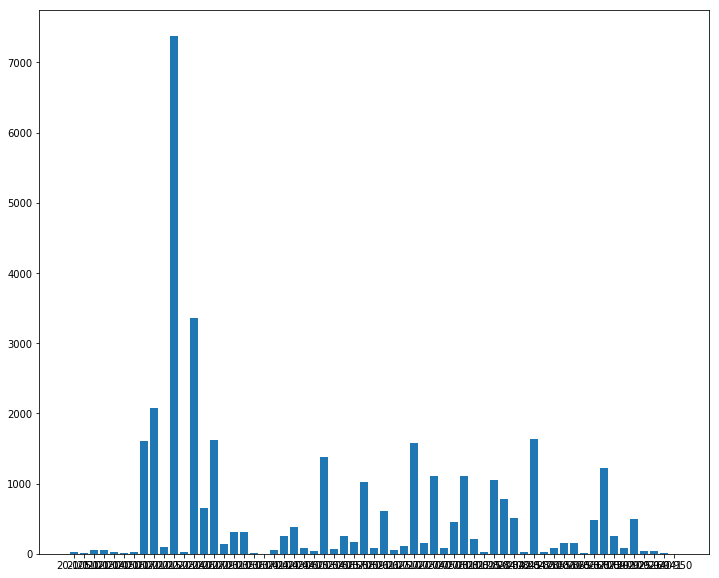

In [77]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
# ax.plot(df_month_company_rev['contract_start_year_month'], df_month_company_rev['rental_revenue'])
# ax.plot(df_month_company_rev['contract_start_year_month'], df_month_company_rev['units_rented']);
ax.bar(df_month_company_rev['product_type'], df_month_company_rev['units_rented'])

In [29]:
from pandas.tools.plotting import scatter_matrix

In [ ]:
attributes = ['']

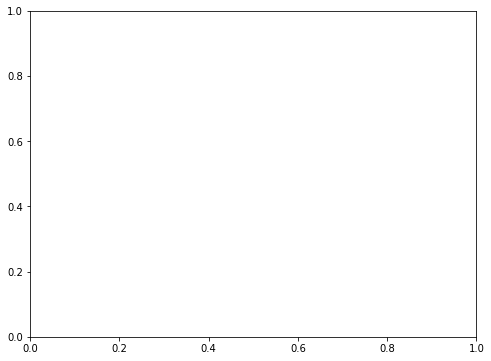

In [16]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
